<a href="https://colab.research.google.com/github/TobiasWinfriedWeber/DSAP_SER/blob/main/CNN_repeated_hap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import basic libraries
import matplotlib.pyplot as plt
import numpy as np
# Mount to drive
from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/drive")
# Import torch
import torch
import torch.nn as nn
import torch.optim as optim
import os
from scipy.io import wavfile
import shutil
import csv
path = "/content/drive" # /content is pretty much the root. you can choose other path in your colab workspace
os.chdir(path)


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cpu


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import math

class SimpleCNN(nn.Module):
    def __init__(self, hidden_neurons, filter_len, filter_shift, maxPoolSize, maxPoolShift):
        super(SimpleCNN, self).__init__()
        self.outCONVsize = math.floor((80e3 - filter_len) / filter_shift + 1)
        self.outMAXPOOLsize = math.floor((self.outCONVsize - maxPoolSize) / maxPoolShift + 1)
        print("Input size fc: " + str(self.outMAXPOOLsize))

        # Convolutional layer
        self.conv1d = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=filter_len, stride=filter_shift)
        # Max-pooling layer
        self.maxpool = nn.MaxPool1d(kernel_size=maxPoolSize, stride=maxPoolShift)
        self.dropout = nn.Dropout(p=0.2)
        # Fully connected (linear) layer
        self.fc = nn.Linear(self.outMAXPOOLsize, hidden_neurons)
        # ReLU activation function for hidden layer
        self.relu = nn.ReLU()
        # Output layer
        self.output_layer = nn.Linear(hidden_neurons, 2)  # Two output classes

    def forward(self, x):
        # Convolutional layer
        x = self.conv1d(x)
        x = self.relu(x)
        # Max-pooling layer
        x = self.maxpool(x)

        # Flatten for fully connected layer
        x = x.view(x.size(0), -1)
        # Fully connected layer
        x = self.fc(x)
        x = self.relu(x)
        # Output layer
        x = self.output_layer(x)
        x = nn.functional.softmax(x, dim=1)  # Apply softmax activation

        return x

**Perform Training**

In [ ]:
# Install required packages
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your CSV file
#csv_path = "/content/drive/My Drive/DSAP/BigProject/DATA/ANGRY_CLASSIFICATION/labels.csv"
csv_path = "/content/drive/My Drive/DSAP/BigProject/DATA/HAPPY_CLASSIFICATION_SAME_REP/labels_sameprobability.csv"
df = pd.read_csv(csv_path)

# Split the data into training, validation, and test sets
# Shuffle the dataframe
df = df.sample(frac=1, random_state=42)
#df = df.head(4000)
temp_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(temp_df, test_size=0.2, random_state=42)

# Define a custom dataset for loading audio files
class AudioDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        file_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        waveform, sample_rate = torchaudio.load(file_name)
        label = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.float32)  # Assuming labels are in the second column

        # Normalize the waveform to be between 0 and 1
        #waveform = (waveform - waveform.min()) / (waveform.max() - waveform.min())
        waveform = 2 * (waveform - waveform.min()) / (waveform.max() - waveform.min()) - 1


        if self.transform:
            waveform = self.transform(waveform)

        return waveform, label

# Set the path to your directory containing audio files
#audio_dir = "/content/drive/My Drive/DSAP/BigProject/DATA/CremaD/AudioWAV_samelength"
audio_dir = "/content/drive/My Drive/DSAP/BigProject/DATA/CremaD/HAP_SAMEPROP_REP"
# Create instances of the custom dataset for training, validation, and test
train_dataset = AudioDataset(dataframe=train_df, root_dir=audio_dir)
val_dataset = AudioDataset(dataframe=val_df, root_dir=audio_dir)
test_dataset = AudioDataset(dataframe=test_df, root_dir=audio_dir)

# Define data loaders
#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
## Settings
sampling_rate = 16e3 #was tested before
#Calculate the number of samples per window for a 25ms window size
kernelCON_len = int(0.025 * sampling_rate)
# move window of one fourth of kernel size
shiftCON_size = int(0.25 * kernelCON_len)
print(f"Kernel size is : {kernelCON_len} Samples")

hidden_neurons = 8
maxPoolLen = 4
maxPoolStride = 4

num_epochs = 10000

Kernel size is : 400 Samples


In [ ]:
# Create an instance of the model, define loss
model = SimpleCNN(hidden_neurons=hidden_neurons, filter_len=kernelCON_len, filter_shift = shiftCON_size, maxPoolSize=maxPoolLen, maxPoolShift=maxPoolStride)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.9, momentum=0.9) # in paper: sgd 0.9, 0.9
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.2) # gamma = 0.2
model.to( device )
criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()

# Early stopping parameters
patience = 50  # Number of epochs with no improvement after which training will be stopped
best_val_loss = float('inf')
counter_no_improve = 0

# Save parameters
trainingloss_per_epoch = []
validationloss_per_epoch = []
accuracy_per_epoch = []

Input size fc: 199


In [ ]:
# Training loop
#max_grad_norm = 100000000.0
dynamic_batch_size = 902
from torch.nn.utils import clip_grad_norm_
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import os


for epoch in range(num_epochs):
    model.train()
    i=0

      # Set your initial batch size
    train_loader_epoch = DataLoader(train_dataset, batch_size=dynamic_batch_size, shuffle=True)
    lenTrainLoader = len(train_loader_epoch)
    for batch in train_loader_epoch:
        input_save, label_save = batch
        if not torch.isnan(input_save.unsqueeze(1)).any():
          inputs, labels = batch
          inputs, labels = inputs.to(device), labels.to(device)

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(inputs)
          #outputs = torch.sigmoid(outputs)
          if i%40 == 0 or i==0:
            #print(labels.unsqueeze(1))
            #print("#######################################################")
            #print(outputs)
            #print(labels)
            #print("#######################################################")
            print("Number batch " + str(i) + " of " + str(lenTrainLoader))
          #if math.isnan(outputs):
          #  print(input_save)
          i+=1
          # Calculate the loss
          loss = criterion(outputs, labels.long())



          # Backward pass
          loss.backward()
          #clip_grad_norm_(model.parameters(), max_grad_norm)

          # Update weights
          optimizer.step()

          i += 1

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            #outputs = torch.sigmoid(outputs)

            # Calculate the loss
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()

            # Accuracy calculation
            predicted = torch.argmax(outputs, dim=1)
            #predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1)).sum().item()

    average_val_loss = val_loss / len(val_loader)
    accuracy = correct / total
    lr_scheduler.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {average_val_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')
    # Append values to the existing lists
    trainingloss_per_epoch.append(loss.cpu().item())
    validationloss_per_epoch.append(average_val_loss)
    accuracy_per_epoch.append(accuracy)
    np.savetxt('/content/drive/My Drive/cnn_softmax_rep_hap/training_loss.csv', trainingloss_per_epoch, delimiter=',')
    np.savetxt('/content/drive/My Drive/cnn_softmax_rep_hap/validation_loss.csv', validationloss_per_epoch, delimiter=',')
    np.savetxt('/content/drive/My Drive/cnn_softmax_rep_hap/accuracy.csv', accuracy_per_epoch, delimiter=',')
    # Learning rate scheduling
    lr_scheduler.step()


    # Early stopping
    if average_val_loss < best_val_loss:
        torch.save(model.state_dict(), '/content/drive/My Drive/cnn_softmax_rep_hap/CNN_PAPER.pth')

        #if dynamic_batch_size*1.5<598:
        #  dynamic_batch_size = int(dynamic_batch_size*1.5)
        best_val_loss = average_val_loss
        counter_no_improve = 0
    else:
        counter_no_improve += 1

    #if counter_no_improve >= patience:
    #    print(f'Early stopping! No improvement for {patience} consecutive epochs.')
    #    break
print('Training finished.')

Number batch 0 of 1
Epoch [1/10000], Loss: 0.7373, Validation Loss: 0.6980, Accuracy: 46.02%
Number batch 0 of 1
Epoch [2/10000], Loss: 0.7425, Validation Loss: 0.6988, Accuracy: 46.02%
Number batch 0 of 1
Epoch [3/10000], Loss: 0.7517, Validation Loss: 0.7020, Accuracy: 46.02%
Number batch 0 of 1
Epoch [4/10000], Loss: 0.7705, Validation Loss: 0.7078, Accuracy: 46.02%
Number batch 0 of 1
Epoch [5/10000], Loss: 0.7930, Validation Loss: 0.7047, Accuracy: 46.02%
Number batch 0 of 1
Epoch [6/10000], Loss: 0.8253, Validation Loss: 0.6917, Accuracy: 46.02%
Number batch 0 of 1
Epoch [7/10000], Loss: 0.8625, Validation Loss: 0.6865, Accuracy: 46.46%
Number batch 0 of 1
Epoch [8/10000], Loss: 0.8920, Validation Loss: 0.6894, Accuracy: 50.44%
Number batch 0 of 1
Epoch [9/10000], Loss: 0.8941, Validation Loss: 0.6849, Accuracy: 50.88%
Number batch 0 of 1
Epoch [10/10000], Loss: 0.8916, Validation Loss: 0.6773, Accuracy: 56.64%
Number batch 0 of 1
Epoch [11/10000], Loss: 0.8867, Validation Loss: 

KeyboardInterrupt: ignored

In [ ]:
model.load_state_dict(torch.load('/content/drive/My Drive/cnn_softmax_rep_hap/CNN_PAPER.pth', map_location=torch.device('cpu')))
model.eval()  # Set the model to evaluation mode

test_loss = 0.0
correct = 0
total = 0
angry_detected = 0

with torch.no_grad():
    i = 0
    len_test = len(test_loader)
    for batch in test_loader:  # Assuming you have a DataLoader for your test set
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        if i % 100 == 0:
            print(str(i) + " / " + str(len_test))
        i += 1

        # Forward pass
        probs = model(inputs)
        loss = criterion(probs, labels.long())  # Use .long() for integer labels in CrossEntropyLoss
        test_loss += loss.item()

        # Accuracy calculation
        predicted = torch.argmax(probs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Angry detection calculation
        angry_detected += ((predicted == 1) & (labels == 1)).sum().item()

average_test_loss = test_loss / len(test_loader)
accuracy = correct / total
angry_det_percentage = angry_detected / total

print(f'Test Loss: {average_test_loss:.4f}, Test Accuracy: {accuracy}, Angry Detection Percentage: {angry_det_percentage}')


0 / 282
100 / 282
200 / 282
Test Loss: 0.6633, Test Accuracy: 0.624113475177305, Angry Detection Percentage: 0.375886524822695


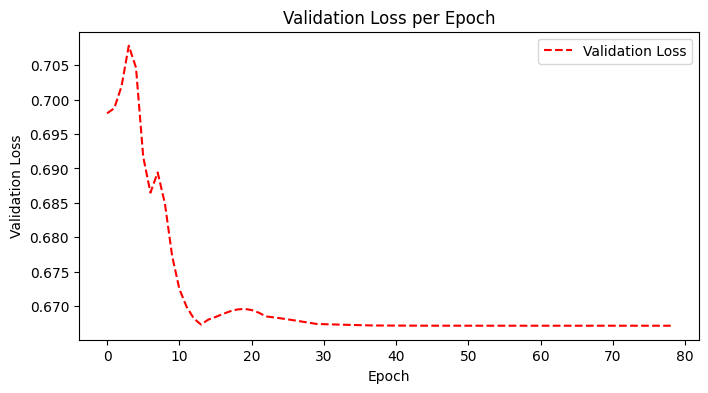

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the CSV file
accuracy_per_epoch = np.loadtxt('/content/drive/My Drive/cnn_softmax_rep_hap/accuracy.csv', delimiter=',')
# Load the data from the CSV files
validation_loss_per_epoch = np.loadtxt('/content/drive/My Drive/cnn_softmax_rep_hap/validation_loss.csv', delimiter=',')
trainingloss_per_epoch = np.loadtxt('/content/drive/My Drive/cnn_softmax_rep_hap/training_loss.csv', delimiter=',')

# Plot for Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(validation_loss_per_epoch, label='Validation Loss', color='red', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss per Epoch')
plt.legend()
plt.show()

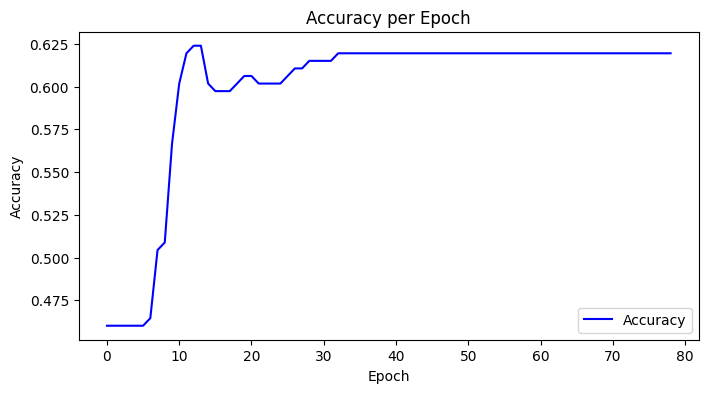

In [3]:
# Plot for Accuracy
plt.figure(figsize=(8, 4))
plt.plot(accuracy_per_epoch, label='Accuracy', color='blue', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()

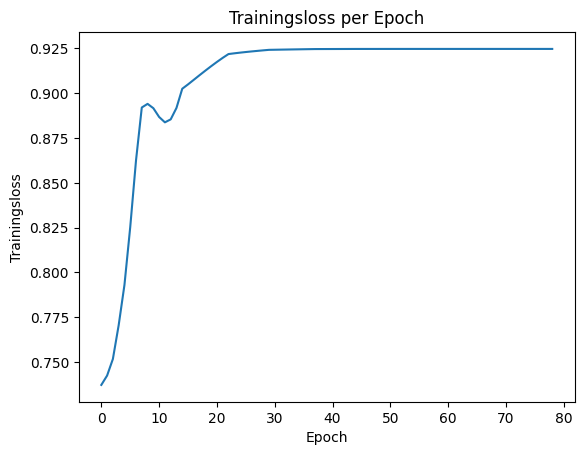

In [4]:
# Plot the data using the index as the x-axis values
plt.plot(trainingloss_per_epoch)
plt.xlabel('Epoch')
plt.ylabel('Trainingsloss')
plt.title('Trainingsloss per Epoch')
plt.show()